# Titanic-tutorial-survival
用到的头文件


In [3]:
import pandas as pd;
import matplotlib.pyplot as plt
import seaborn as sns
# 数据处理
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# 评价指标
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
# 分类器
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC



## Step 1 Data Clean

look at train.csv

In [4]:
train_data_set = pd.read_csv('./Dateset/train.csv')
train_data_set.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [3]:
train_data_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


对训练数据进行审视，发现如下问题
- Name , Ticket , PassengerId 这三个属性值对于一个人是否能存活下来是无关的,而且在本数据集中这三个属性值都是unique的,即每行数据的这三个属性值唯一,没有实际参考意义
- 对于 Cabin 属性值, 有意义的值只占到23%,无实际参考价值;
- 对于 Age 属性，我们再单独进行考虑

In [4]:
# 重新清洗数据

# 读取CSV文件
data = pd.read_csv('./Dateset/train.csv')
# 选择需要的列
train_data_set = data[["Survived", "Pclass","Sex","Age","SibSp","Parch","Fare","Embarked"]]

# 或者使用 loc 方法
# selected_columns = data.loc[:, ["列1", "列2"]]

# 指定要去除的列
# columns_to_drop = ["PassengerId", "Name","Cabin","Ticket"]
# 去除指定的列
# data_without_columns = data.drop(columns=columns_to_drop)

# 显示所选列的数据
train_data_set.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S
5,0,3,male,NaN,0,0,8.4583,Q
6,0,1,male,54.0,0,0,51.8625,S
7,0,3,male,2.0,3,1,21.0750,S
8,1,3,female,27.0,0,2,11.1333,S
9,1,2,female,14.0,1,0,30.0708,C


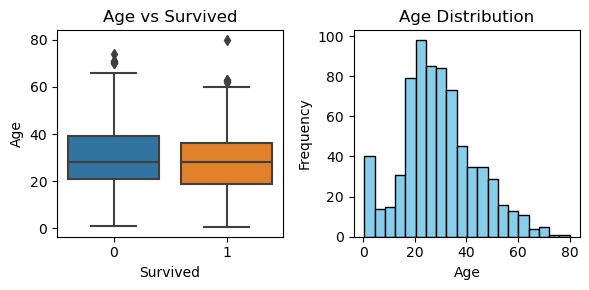

In [5]:
# 创建一个2x1的子图布局
fig, axs = plt.subplots(1, 2, figsize=(6, 3))

# 绘制箱线图
sns.boxplot(x='Survived', y='Age', data=train_data_set, ax=axs[0])
axs[0].set_title('Age vs Survived')
axs[0].set_xlabel('Survived')
axs[0].set_ylabel('Age')

# 绘制直方图
axs[1].hist(train_data_set['Age'], bins=20, color='skyblue', edgecolor='black')
axs[1].set_title('Age Distribution')
axs[1].set_xlabel('Age')
axs[1].set_ylabel('Frequency')

# 调整子图之间的间距
plt.tight_layout()

# 显示图形
plt.show()

观察到年龄值对于死亡的关系,因此以年龄平均值对NaN补齐，Embarked以最多出现值补全

In [6]:
# 计算Age的平均值
age_mean = train_data_set['Age'].mean()
# 使用平均值填充NaN值
train_data_set['Age'].fillna(age_mean, inplace=True)
# 找到Embarked列中出现最多的值
most_common_embarked = train_data_set['Embarked'].mode()[0]
# 使用出现最多的值填充NaN值
train_data_set['Embarked'].fillna(most_common_embarked, inplace=True)

train_data_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  891 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


d:\Compiler_software\Anaconda\envs\py\lib\site-packages\pandas\core\generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


对非数据类型属性值进行编码

In [7]:
# 使用独热编码处理分类数据
train_data_set = pd.get_dummies(train_data_set, columns=['Sex', 'Embarked'])

# 显示处理后的数据
train_data_set.head(10)

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.000000,1,0,7.2500,0,1,0,0,1
1,1,1,38.000000,1,0,71.2833,1,0,1,0,0
2,1,3,26.000000,0,0,7.9250,1,0,0,0,1
3,1,1,35.000000,1,0,53.1000,1,0,0,0,1
4,0,3,35.000000,0,0,8.0500,0,1,0,0,1
5,0,3,29.699118,0,0,8.4583,0,1,0,1,0
6,0,1,54.000000,0,0,51.8625,0,1,0,0,1
7,0,3,2.000000,3,1,21.0750,0,1,0,0,1
8,1,3,27.000000,0,2,11.1333,1,0,0,0,1
9,1,2,14.000000,1,0,30.0708,1,0,1,0,0


In [8]:
train_data_set.info()
# 假设你的分类结果列名为 'target'
target = train_data_set['Survived']

# 删除分类结果列以及不需要的列（例如 'name'）
features = train_data_set.drop(['Survived'], axis=1)

# 训练随机森林分类器
rf_classifier = RandomForestClassifier()
rf_classifier.fit(features, target)

# 获取特征重要性
feature_importances = rf_classifier.feature_importances_

# 打印每个属性对于分类结果的重要性
for i, importance in enumerate(feature_importances):
    print(f"Feature '{features.columns[i]}': {importance}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int64  
 1   Pclass      891 non-null    int64  
 2   Age         891 non-null    float64
 3   SibSp       891 non-null    int64  
 4   Parch       891 non-null    int64  
 5   Fare        891 non-null    float64
 6   Sex_female  891 non-null    uint8  
 7   Sex_male    891 non-null    uint8  
 8   Embarked_C  891 non-null    uint8  
 9   Embarked_Q  891 non-null    uint8  
 10  Embarked_S  891 non-null    uint8  
dtypes: float64(2), int64(4), uint8(5)
memory usage: 46.2 KB
Feature 'Pclass': 0.0846088280170957
Feature 'Age': 0.2589961270825313
Feature 'SibSp': 0.04548027509824577
Feature 'Parch': 0.035657756893031
Feature 'Fare': 0.25190301919489533
Feature 'Sex_female': 0.1499083974479536
Feature 'Sex_male': 0.14008973896687285
Feature 'Embarked_C': 0.01360859077844856

## Step 2 Moddel choose && train

### 训练集初始化

In [9]:
# 将第一列作为标签，其余列作为特征
labels = train_data_set.iloc[:, 0]  # 第一列作为标签
features = train_data_set.iloc[:, 1:]  # 其余列作为特征

# 显示特征和标签
print("Labels (First Column):")
print(labels.head())
print("\nFeatures (Other Columns):")
print(features.head())
# 划分数据集为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

Labels (First Column):
0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

Features (Other Columns):
   Pclass   Age  SibSp  Parch     Fare  Sex_female  Sex_male  Embarked_C  \
0       3  22.0      1      0   7.2500           0         1           0   
1       1  38.0      1      0  71.2833           1         0           1   
2       3  26.0      0      0   7.9250           1         0           0   
3       1  35.0      1      0  53.1000           1         0           0   
4       3  35.0      0      0   8.0500           0         1           0   

   Embarked_Q  Embarked_S  
0           0           1  
1           0           0  
2           0           1  
3           0           1  
4           0           1  



### Logistic Regression

In [10]:
# 初始化 Logistic Regression 模型
lr_model = LogisticRegression(random_state=42,solver='liblinear')

# 训练模型
lr_model.fit(X_train, y_train)

# 预测测试集
lr_predictions = lr_model.predict(X_test)

# 计算准确率
lr_accuracy = accuracy_score(y_test, lr_predictions)
print("Logistic Regression Accuracy:", lr_accuracy)

Logistic Regression Accuracy: 0.7932960893854749


In [39]:
# 使用 k 折交叉验证评估模型
scores = cross_val_score(lr_model, X_train, y_train, cv=5)  # cv=5表示使用5折交叉验证
print("Cross-Validation Accuracy:", scores)

# 计算交叉验证准确率的均值和标准差
print("Mean Accuracy:", scores.mean())
print("Standard Deviation of Accuracy:", scores.std())

Cross-Validation Accuracy: [0.82517483 0.8041958  0.78873239 0.74647887 0.82394366]
Mean Accuracy: 0.7977051117896188
Standard Deviation of Accuracy: 0.028947583425917658


### SVM

In [11]:
# 初始化支持向量机模型
svm_model = SVC(random_state=42,probability=True)

# 训练模型
svm_model.fit(X_train, y_train)

# 预测测试集
svm_predictions = svm_model.predict(X_test)

# 计算准确率
svm_accuracy = accuracy_score(y_test, svm_predictions)
print("SVM Accuracy:", svm_accuracy)

SVM Accuracy: 0.659217877094972


In [36]:
# 使用 k 折交叉验证评估模型
scores = cross_val_score(svm_model, X_train, y_train, cv=5)  # cv=5表示使用5折交叉验证
print("Cross-Validation Accuracy:", scores)

# 计算交叉验证准确率的均值和标准差
print("Mean Accuracy:", scores.mean())
print("Standard Deviation of Accuracy:", scores.std())

Cross-Validation Accuracy: [0.69230769 0.67832168 0.64084507 0.65492958 0.66901408]
Mean Accuracy: 0.6670836206047474
Standard Deviation of Accuracy: 0.017902271954782056


### DecisionTree

In [12]:
# 初始化决策树模型
dt_model = DecisionTreeClassifier(random_state=42)

# 训练模型
dt_model.fit(X_train, y_train)

# 预测测试集
dt_predictions = dt_model.predict(X_test)

# 计算准确率
dt_accuracy = accuracy_score(y_test, dt_predictions)
print("Decision Tree Accuracy:", dt_accuracy)

Decision Tree Accuracy: 0.7877094972067039


In [37]:
# 使用 k 折交叉验证评估模型
scores = cross_val_score(dt_model, X_train, y_train, cv=5)  # cv=5表示使用5折交叉验证
print("Cross-Validation Accuracy:", scores)

# 计算交叉验证准确率的均值和标准差
print("Mean Accuracy:", scores.mean())
print("Standard Deviation of Accuracy:", scores.std())

Cross-Validation Accuracy: [0.74825175 0.76223776 0.75352113 0.73239437 0.76760563]
Mean Accuracy: 0.7528021274500147
Standard Deviation of Accuracy: 0.012213718798092287


### RandomForest

In [13]:
# 初始化随机森林分类器模型
rf_model = RandomForestClassifier(random_state=42)

# 训练模型
rf_model.fit(X_train, y_train)

# 预测测试集
predictions = rf_model.predict(X_test)

# 计算准确率
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.8156424581005587


In [38]:
# 使用 k 折交叉验证评估模型
scores = cross_val_score(rf_model, X_train, y_train, cv=5)  # cv=5表示使用5折交叉验证
print("Cross-Validation Accuracy:", scores)

# 计算交叉验证准确率的均值和标准差
print("Mean Accuracy:", scores.mean())
print("Standard Deviation of Accuracy:", scores.std())

Cross-Validation Accuracy: [0.8041958  0.75524476 0.8028169  0.78169014 0.83802817]
Mean Accuracy: 0.796395154141633
Standard Deviation of Accuracy: 0.02736782655608784


### 集成学习

In [41]:
# 初始化单个分类器
clf1 = LogisticRegression(random_state=42, solver='liblinear')
clf2 = DecisionTreeClassifier(random_state=42)
clf3 = SVC(random_state=42,probability=True)

# 初始化集成学习模型（投票分类器）
voting_clf = VotingClassifier(estimators=[('lr', clf1), ('dt', clf2), ('svc', clf3)], voting='soft')

# 训练集成学习模型
voting_clf.fit(X_train, y_train)

# 预测测试集
predictions = voting_clf.predict(X_test)

# 计算准确率
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.8324022346368715


In [42]:
# 使用 k 折交叉验证评估模型
scores = cross_val_score(voting_clf, X_train, y_train, cv=5)  # cv=5表示使用5折交叉验证
print("Cross-Validation Accuracy:", scores)

# 计算交叉验证准确率的均值和标准差
print("Mean Accuracy:", scores.mean())
print("Standard Deviation of Accuracy:", scores.std())

Cross-Validation Accuracy: [0.78321678 0.8041958  0.81690141 0.76760563 0.81690141]
Mean Accuracy: 0.7977642076233625
Standard Deviation of Accuracy: 0.01946790937536489


## Step 3 模型在陌生的测试集上预测效果

In [15]:
test_data_set = pd.read_csv('./Dateset/test.csv')
test_data_set = test_data_set[["Pclass","Sex","Age","SibSp","Parch","Fare","Embarked"]]
test_data_set = pd.get_dummies(test_data_set, columns=['Sex', 'Embarked'])
test_data_set.head(10)

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,34.5,0,0,7.8292,0,1,0,1,0
1,3,47.0,1,0,7.0000,1,0,0,0,1
2,2,62.0,0,0,9.6875,0,1,0,1,0
3,3,27.0,0,0,8.6625,0,1,0,0,1
4,3,22.0,1,1,12.2875,1,0,0,0,1
5,3,14.0,0,0,9.2250,0,1,0,0,1
6,3,30.0,0,0,7.6292,1,0,0,1,0
7,2,26.0,1,1,29.0000,0,1,0,0,1
8,3,18.0,0,0,7.2292,1,0,1,0,0
9,3,21.0,2,0,24.1500,0,1,0,0,1


NaN 处理

In [16]:
# 计算Age的平均值
age_mean = test_data_set['Age'].mean()
# 使用平均值填充NaN值
test_data_set['Age'].fillna(age_mean, inplace=True)
# 找到Embarked列中出现最多的值
most_common_embarked = train_data_set['Fare'].mode()[0]
# 使用出现最多的值填充NaN值
test_data_set['Fare'].fillna(most_common_embarked, inplace=True)

In [17]:
test_data_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass      418 non-null    int64  
 1   Age         418 non-null    float64
 2   SibSp       418 non-null    int64  
 3   Parch       418 non-null    int64  
 4   Fare        418 non-null    float64
 5   Sex_female  418 non-null    uint8  
 6   Sex_male    418 non-null    uint8  
 7   Embarked_C  418 non-null    uint8  
 8   Embarked_Q  418 non-null    uint8  
 9   Embarked_S  418 non-null    uint8  
dtypes: float64(2), int64(3), uint8(5)
memory usage: 18.5 KB


In [18]:
lable_data_set = pd.read_csv('./Dateset/gender_submission.csv')
lable_data_set = lable_data_set[["Survived"]]
lable_data_set.head(10)

,Survived
0,0
1,1
2,0
3,0
4,1
5,0
6,1
7,0
8,1
9,0


指标评价

In [20]:
# 假设 models 是一个包含多个训练好的模型的列表
models = [rf_model,lr_model,svm_model,dt_model,voting_clf]  # 

In [21]:
for model in models:
    print(model.__class__.__name__)
    predictions = model.predict(test_data_set)
    # 计算混淆矩阵
    conf_matrix = confusion_matrix(lable_data_set, predictions)
    print("Confusion Matrix:")
    print(conf_matrix)
    # 计算分类报告
    class_report = classification_report(lable_data_set, predictions)
    print("Classification Report:")
    print(class_report)

RandomForestClassifier
Confusion Matrix:
[[234  32]
 [ 33 119]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       266
           1       0.79      0.78      0.79       152

    accuracy                           0.84       418
   macro avg       0.83      0.83      0.83       418
weighted avg       0.84      0.84      0.84       418

LogisticRegression
Confusion Matrix:
[[254  12]
 [  7 145]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       266
           1       0.92      0.95      0.94       152

    accuracy                           0.95       418
   macro avg       0.95      0.95      0.95       418
weighted avg       0.96      0.95      0.95       418

SVC
Confusion Matrix:
[[236  30]
 [115  37]]
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.89      0.76       266

In [22]:
with open("model_results.txt", "w") as file:
    for model in models:
        file.write(model.__class__.__name__ + "\n")
        predictions = model.predict(test_data_set)
        # 计算混淆矩阵
        conf_matrix = confusion_matrix(lable_data_set, predictions)
        file.write("Confusion Matrix:\n")
        file.write(str(conf_matrix) + "\n")
        # 计算分类报告
        class_report = classification_report(lable_data_set, predictions)
        file.write("Classification Report:\n")
        file.write(class_report + "\n")


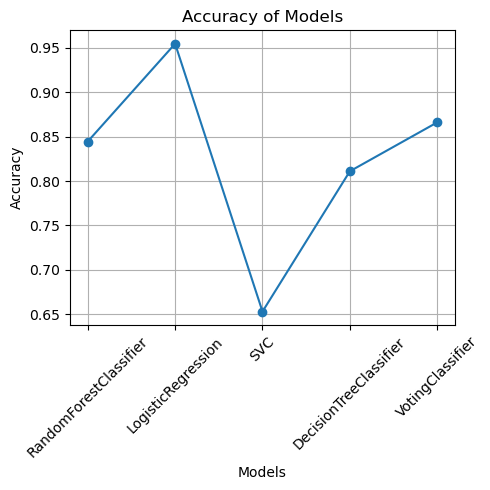

In [31]:
accuracies = []

for model in models:
    predictions = model.predict(test_data_set)
    accuracy = accuracy_score(lable_data_set, predictions)
    accuracies.append(accuracy)

# 创建折线图
plt.figure(figsize=(5, 5))
plt.plot([model.__class__.__name__ for model in models], accuracies, marker='o', linestyle='-')
plt.title('Accuracy of Models')
plt.ylabel('Accuracy')
plt.xlabel('Models')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# 显示图形
plt.show()

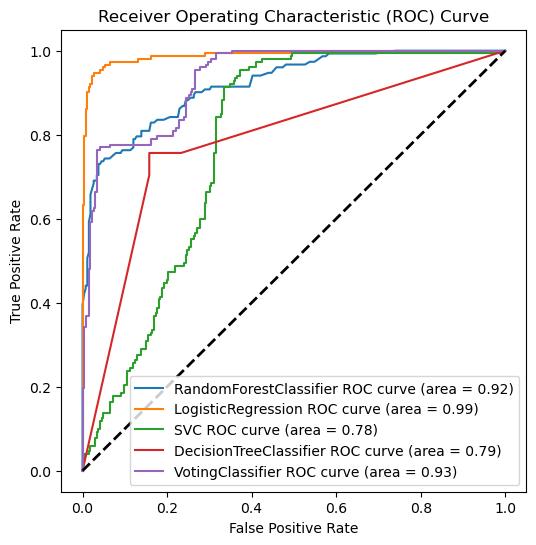

In [23]:
plt.figure(figsize=(6, 6))

# 遍历每个模型并计算其ROC曲线
for model in models:
    # 计算每个模型的预测概率
    probas = model.predict_proba(test_data_set)
    # 提取正类别的预测概率
    fpr, tpr, thresholds = roc_curve(lable_data_set, probas[:, 1])
    # 计算AUC值
    roc_auc = auc(fpr, tpr)
    # 绘制ROC曲线
    plt.plot(fpr, tpr, label='%s ROC curve (area = %0.2f)' % (model.__class__.__name__, roc_auc))

# 绘制随机猜测的直线
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# 添加标题和标签
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# 显示图形
plt.show()